In [1]:
import itertools
import random
from collections import Counter
import joblib
import pickle
import pandas as pd
import numpy as np
import re
from keras import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Bidirectional, LSTM
from keras.utils.np_utils import to_categorical
from nltk.corpus import stopwords
from parsivar import Normalizer
import emoji
import emojies
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

In [2]:
class CleanText:
    def __init__(self, data_frame, column_name):
        self.cln_list = data_frame[column_name].tolist()
    def __new__(cls, data_frame, column_name,*args, **kwargs):
        data_frame[column_name] = data_frame[column_name].apply(lambda x: x[:400])
        return super().__new__(cls,*args, **kwargs)
    def clean_punctual(self):
        tmp_lst = list(map(lambda x: re.sub(r'https?:\S*', ' ', x), self.cln_list))
        tmp_lst = list(map(lambda x: re.sub(r'@[A-Za-z0-9]\S+', ' ', x), tmp_lst))
        tmp_lst = list(map(lambda x: re.sub(r'[0-9]\S+', ' ', x), tmp_lst))
        self.cln_list = list(map(lambda x: re.sub(r'#|_|:|/d+', ' ', x), tmp_lst))
        return self.cln_list
    def normalize_text(self):
        normalizer = Normalizer(pinglish_conversion_needed=True)
        cln_list = list(map(lambda x: normalizer.normalize(x), self.cln_list))
        self.cln_list = list(map(lambda x: ''.join(ch for ch, _ in itertools.groupby(x)), cln_list))
        return self.cln_list
    def remove_stop_words(self):
        stop_words = set(stopwords.words('RD_persian_01'))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if not w in stop_words]), self.cln_list))
        return self.cln_list
    def extract_emojis(self):
        self.cln_list = list(map(lambda x: ''.join((' '+c+' ') if c in emoji.UNICODE_EMOJI['en'] else c for c in x), self.cln_list))
        return self.cln_list
    def convert_emojies(self):
        self.cln_list = list(map(lambda x: emojies.replace(x), self.cln_list))
        return self.cln_list
    def frequency_words(self):
        freq = dict(Counter(" ".join(self.cln_list).split()))
        sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)
        sort_orders = sort_orders[:4000]
        # print(sort_orders)
        print(len(sort_orders))
        most_common_word = [i[0] for i in sort_orders]
        most_common_word = set(most_common_word)
        print(most_common_word)
        # print(len(most_common_word))
        self.cln_list = list(map(lambda x: ' '.join([w for w in x.split() if w in most_common_word]), self.cln_list))
        return self.cln_list

In [3]:
class EncodeText:
    def __init__(self,train_text):
        self.train_text = train_text
    def create_tokenizer(self):
        tokenizer = Tokenizer()
        tokenizer.fit_on_texts(self.train_text)
        return tokenizer
    def encode_text(self,tokenizer, input_list, max_length):
        # integer encode
        encoded = tokenizer.texts_to_sequences(input_list)
        # pad encoded sequences
        padded = pad_sequences(encoded, maxlen=max_length, padding='post')
        return padded
    def label_encoder(self, tag):
        le = LabelEncoder()
        tmp_tag = le.fit_transform(tag)
        encode_tag = to_categorical(np.array(tmp_tag))
        return encode_tag

In [ ]:
# data_df = pd.read_excel('dataset.2.0.0.xlsx', index_col= False)
# fig, ax = plt.subplots()
# ax.hist(data_df['احساس'])
# plt.show()

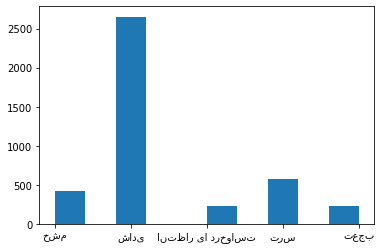

In [4]:
# data_df = pd.read_csv('dataset/comp_dataset2.csv', index_col= False)
data_df = pd.read_excel('dataset/dataset04.xlsx', index_col= False)

fig, ax = plt.subplots()
ax.hist(data_df['tag'])
plt.show()


In [5]:
# call_cleantext = CleanText(data_df, 'متن توییت')
call_cleantext = CleanText(data_df, 'caption')
# call_cleantext = CleanText(data_df, 'Text')
get_pun_list = call_cleantext.clean_punctual()
get_ex_emoji = call_cleantext.extract_emojis()
get_emoji_list = call_cleantext.convert_emojies()
get_norm_list = call_cleantext.normalize_text()
get_rm_sw_list = call_cleantext.remove_stop_words()
get_most_com_list = call_cleantext.frequency_words()
# get_most_com_list = get_most_com_list
# Remove None Value Data

4000
{'متنوع', 'افرین', 'ارزانی', 'استراتژیست', 'رضای', 'اطهر', 'میکنید', 'وهمه', 'ان\u200cی', 'سیر', 'سر\u200cدار', 'ی', 'راس', 'مداری', 'پنجاه', 'پاس', 'نجات', 'برشمردند', 'چیه', 'کجاها', 'رنگ', '؛', 'غصه', 'نتواند', 'افتاده', 'علامت', 'هرچه', 'مشاهده', 'نخواهیم', 'نمیشود', 'مسئولیت', 'دقیق', 'بالاترین', 'تا\u200cان', 'حرام', 'هم\u200cان', 'کشتند', 'دوره\u200cای', 'عاشقانه', 'همیشه', 'بزند', 'گوه', 'زور', 'تحق', 'خبیث\u200cترین', 'عینی', 'کدوم', 'باشد', 'مردم\u200cداری', 'پایه\u200cی', 'پمپئو', 'ابراهیم', 'اقتصاد', 'خط', 'تیر', 'نترس', 'نکنید', 'مرا', 'هزار', 'حکیمی', 'ونیاورد', 'توصیه', 'خطاب', 'نشد', 'شکل\u200cگیری', 'زندگیم', 'تیری', 'سبز', 'کلمه', 'وجود', 'جدا', 'برگزاری', 'ابری', 'اینا', 'صحبت', 'ابوسفیان', 'فرموده', 'ارزش\u200cهای', 'رجعت', 'نشر', 'حادثه\u200cی', 'خودسازی', 'بهم', 'همسایه', 'بصیرت', 'عقب', 'صفات', 'و\u200cای', 'برسم', 'صدر', 'حتی', 'ظلموا\u200cای', 'میراث', 'محافظت', 'می\u200cماند', 'قلبمان', 'دستش', '."', 'میدان', 'لطفا', 'پرورش', 'معرفت', 'رفتنش', 'وعده', 'عل

In [5]:
get_most_com_list = call_cleantext.frequency_words()

4000
4000


In [13]:
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['احساس'])))
# init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
init_List_prepared = list(map(lambda x: [x[0], x[1]], zip(get_most_com_list, data_df['tag'])))
print(len(init_List_prepared))
init_List_prepared = list(filter(lambda x: len(x[0].split())>2, init_List_prepared))
print(len(init_List_prepared))

random.shuffle(init_List_prepared)

var1 = list(filter(lambda x: x[1]=='شادی', init_List_prepared))
var2 = list(filter(lambda x: x[1]=='خشم', init_List_prepared))
var3 = list(filter(lambda x: x[1]=='غم', init_List_prepared))
var4 = list(filter(lambda x: x[1]=='خنثی', init_List_prepared))
var5 = list(filter(lambda x: x[1]=='امید', init_List_prepared))
var6 = list(filter(lambda x: x[1]=='ترس', init_List_prepared))
var7 = list(filter(lambda x: x[1]=='تعجب', init_List_prepared))
var8 = list(filter(lambda x: x[1]=='تحسین یا اعتماد', init_List_prepared))

# List_prepared = var1[:1500]+var2[:1500]+var3[:1000]+var4[:1000]+var5[:1200]+var6[:700]+var7[:500]+var8[:1500]
List_prepared = var1[:700]+var2[:500]
random.shuffle(List_prepared)

# List_prepared = init_List_prepared

4103
4103


In [14]:
text, tag = zip(*List_prepared)
train_text, test_text, train_tag, test_tag = train_test_split(text, tag, test_size=0.2, random_state=1)

In [15]:
call_encodetext = EncodeText(train_text)
tokenizer = call_encodetext.create_tokenizer()
vocab_size = len(tokenizer.word_index) + 1
print(vocab_size)
max_len = 40
encode_train_text = call_encodetext.encode_text(tokenizer, train_text, max_len)
encode_test_text = call_encodetext.encode_text(tokenizer, test_text, max_len)
encode_train_tag = call_encodetext.label_encoder(train_tag)
encode_test_tag = call_encodetext.label_encoder(test_tag)
num_cat = encode_train_tag.shape[1]

3015


In [16]:
# single Bidir layer
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=max_len))
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.3)))
# model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.3)))
model.add(Dense(num_cat, activation='softmax'))
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 100)           301500    
                                                                 
 bidirectional_1 (Bidirectio  (None, 200)              160800    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 2)                 402       
                                                                 
Total params: 462,702
Trainable params: 462,702
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fitting Network
m = model.fit(encode_train_text, encode_train_tag, epochs=10, verbose=2)
# Evaluating Network
loss, acc = model.evaluate(encode_test_text, encode_test_tag, verbose=0)
print('Test Accuracy: %f' % (acc * 100))
print('Test loss: %f' % loss)
# !khashm, khonsa, shadi, gham of 1e4 51%

Epoch 1/10
29/29 - 7s - loss: 0.5666 - accuracy: 0.7233 - 7s/epoch - 225ms/step
Epoch 2/10
29/29 - 2s - loss: 0.2566 - accuracy: 0.9000 - 2s/epoch - 63ms/step
Epoch 3/10
29/29 - 2s - loss: 0.0790 - accuracy: 0.9678 - 2s/epoch - 65ms/step
Epoch 4/10
29/29 - 2s - loss: 0.0370 - accuracy: 0.9911 - 2s/epoch - 63ms/step
Epoch 5/10
29/29 - 2s - loss: 0.0125 - accuracy: 0.9967 - 2s/epoch - 63ms/step
Epoch 6/10
29/29 - 2s - loss: 0.0082 - accuracy: 0.9989 - 2s/epoch - 68ms/step
Epoch 7/10
29/29 - 2s - loss: 0.0101 - accuracy: 0.9967 - 2s/epoch - 65ms/step
Epoch 8/10
29/29 - 2s - loss: 0.0069 - accuracy: 0.9978 - 2s/epoch - 66ms/step
Epoch 9/10
29/29 - 2s - loss: 0.0040 - accuracy: 0.9989 - 2s/epoch - 67ms/step
Epoch 10/10
29/29 - 2s - loss: 0.0044 - accuracy: 0.9978 - 2s/epoch - 65ms/step
Test Accuracy: 92.477876
Test loss: 0.270185


In [20]:
with open('BiLSTM_3_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# # # loading
# # with open('BiLSTM_3_tokenizer.pickle', 'rb') as handle:
# #     tokenizer = pickle.load(handle)
# Save Model
joblib.dump(model, 'BiLSTM_3_model.joblib')


INFO:tensorflow:Assets written to: ram://c3d56e1f-a713-404b-bc7a-8351bb2805bd/assets


INFO:tensorflow:Assets written to: ram://c3d56e1f-a713-404b-bc7a-8351bb2805bd/assets


['BiLSTM_3_model.joblib']

In [ ]:
# test_df = pd.DataFrame()
# test_df['train_text'] = train_text
# test_df['tag_text'] = train_tag
# test_df['encode_train_tag'] = encode_train_tag.tolist()
# test_df.to_excel('test2_df.xlsx', index=False)

In [18]:
tmp_df = pd.DataFrame()
comment = train_text
tmp_df['tmp_caption']=comment
print(tmp_df)
tmp_call_cleantext = CleanText(tmp_df, 'tmp_caption')
tmp_get_ex_emoji = tmp_call_cleantext.extract_emojis()
print(tmp_get_ex_emoji)
tmp_get_emoji_list = tmp_call_cleantext.convert_emojies()
tmp_get_norm_list = tmp_call_cleantext.normalize_text()
print(tmp_get_norm_list)

list_a = []
i = 0
for item in tmp_get_norm_list:
    i += 1
    # print(i)
    comment_list = item
    instance = tokenizer.texts_to_sequences(comment_list)
    flat_list = []
    for sublist in instance:
        for item in sublist:
            flat_list.append(item)

    flat_list = [flat_list]

    instance = pad_sequences(flat_list, padding='post', maxlen=max_len)

    output = model.predict(instance)
    list_a.append(output)
# print(list_a)
train_df = pd.DataFrame()
train_df['train_text'] = train_text
train_df['tag_text'] = train_tag
train_df['encode_train_tag'] = encode_train_tag.tolist()
train_df['my_model'] = list_a
train_df.to_excel('train2_df.xlsx', index=False)

                                           tmp_caption
0    شهادت سردار سلیمانی تاریخ ثبت عنوان یک نقطه رو...
1    اشک اغاز جنون ، تماشا سخت بغض علی غم زهرا سخت ...
2    مرا شهید کنی شفاعت میکنم . دست‌نوشته شهید حاج ...
3    شهادت سردار دلها روز تجلی دوباره ازادگی شجاعت ...
4    شهادت شهید سلیمانی بی‌شک ، مهمترین توصیف رهبر ...
..                                                 ...
895  گریه بگفتند سردار نیامد صد ناله حسرت سپهدار نی...
896  حاج قاسم سلیمانی تمام علمای جهان یک طرف باشند ...
897  ای ، فکر می‌کنید دوست خدا هستید ارزوی مرگ کنید...
898         لعنت جماعتی عکست استفاده رفتار میکن . hero
899  اشک اغاز جنون ! تماشا سخت بغض علی خشم زهرا سخت...

[900 rows x 1 columns]
['شهادت سردار سلیمانی تاریخ ثبت عنوان یک نقطه روشن . شهید سلیمانی ، قهرمان ملت ایران قهرمان امت اسلامی . حبیب hero', 'اشک اغاز جنون ، تماشا سخت بغض علی غم زهرا سخت خون وجه سلوک سالک باقی\u200cست کشته مالک ، غیرت مالک باقی\u200cست . سفیر عشق hero', 'مرا شهید کنی شفاعت میکنم . دست\u200cنوشته شهید حاج قاسم سلیمانی اشت

In [19]:
df = pd.read_excel('train2_df.xlsx')
list_b = df['my_model']
list_c = list(map(lambda x: list(x[2:-2].split(" ")), list_b))
list_c = list(map(lambda x: list(filter(None, x)), list_c))

list_d = list(map(lambda x: [re.sub('\n','', i) for i in x], list_c))

list_e = list(map(lambda x: [float(i) for i in x], list_d))
list_f = list(map(lambda x: x.index(max(x)), list_e))
train_df['my_model2'] = list_f
train_df.to_excel('train2_df.xlsx', index=False)
